## Plot cancer type prediction results

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au

In [2]:
# set results directory
results_dir = Path(cfg.results_dir, 'cancer_type').resolve()

In [3]:
# load raw data
results_df = au.load_cancer_type_prediction_results(results_dir, 'cancer_type')
print(results_df.shape)
results_df.head()

(2700, 9)


,auroc,aupr,cancer_type,training_data,signal,seed,data_type,fold,experiment
0,0.98013,0.69226,HNSC,methylation,signal,42,train,0,cancer_type
1,0.97116,0.56608,HNSC,methylation,signal,42,test,0,cancer_type
2,0.96767,0.49104,HNSC,methylation,signal,42,cv,0,cancer_type
3,0.97838,0.63986,HNSC,methylation,signal,42,train,1,cancer_type
4,0.98098,0.73787,HNSC,methylation,signal,42,test,1,cancer_type


In [4]:
expression_df = (
    results_df[results_df.training_data == 'expression']
        .drop(columns=['training_data'])
)
expression_results_df = au.compare_results(expression_df,
                                           identifier='cancer_type',
                                           metric='aupr',
                                           correction=True,
                                           correction_method='fdr_bh',
                                           correction_alpha=0.001,
                                           verbose=True)
expression_results_df.sort_values(by='p_value').head(n=10)

,identifier,delta_mean,p_value,corr_pval,reject_null
32,UVM,0.987189,1.965954e-32,6.487650e-31,True
14,LGG,0.932533,8.908975e-32,1.469981e-30,True
15,LIHC,0.947121,5.414586e-31,5.956045e-30,True
22,PRAD,0.943061,4.596693e-30,3.792272e-29,True
28,THCA,0.943469,3.561681e-28,2.350710e-27,True
21,PCPG,0.974578,2.716160e-27,1.493888e-26,True
27,TGCT,0.970647,1.355018e-26,6.387942e-26,True
2,BRCA,0.879973,4.782931e-26,1.972959e-25,True
25,SKCM,0.947655,3.051930e-25,1.119041e-24,True
29,THYM,0.971184,3.676045e-25,1.132516e-24,True


In [5]:
methylation_df = (
    results_df[results_df.training_data == 'methylation']
        .drop(columns=['training_data'])
)
methylation_results_df = au.compare_results(methylation_df,
                                            identifier='cancer_type',
                                            metric='aupr',
                                            correction=True,
                                            correction_method='fdr_bh',
                                            correction_alpha=0.001,
                                            verbose=True)
methylation_results_df.sort_values(by='p_value').head(n=10)

shapes unequal for ACC, skipping
shapes unequal for BLCA, skipping
shapes unequal for BRCA, skipping
shapes unequal for CESC, skipping
shapes unequal for CHOL, skipping
shapes unequal for COAD, skipping
shapes unequal for DLBC, skipping
shapes unequal for ESCA, skipping
shapes unequal for GBM, skipping
shapes unequal for HNSC, skipping
shapes unequal for KICH, skipping
shapes unequal for KIRC, skipping
shapes unequal for KIRP, skipping
shapes unequal for LAML, skipping
shapes unequal for LGG, skipping
shapes unequal for LIHC, skipping
shapes unequal for LUAD, skipping
shapes unequal for LUSC, skipping
shapes unequal for MESO, skipping
shapes unequal for OV, skipping
shapes unequal for PAAD, skipping
shapes unequal for PCPG, skipping
shapes unequal for PRAD, skipping
shapes unequal for READ, skipping
shapes unequal for SARC, skipping
shapes unequal for SKCM, skipping
shapes unequal for STAD, skipping


,identifier,delta_mean,p_value,corr_pval,reject_null
0,TGCT,0.966988,1.710658e-12,8.199436e-12,True
1,THCA,0.943130,2.733145e-12,8.199436e-12,True
3,UCEC,0.885210,1.731636e-10,3.463273e-10,True
2,THYM,0.849091,5.435201e-09,8.152802e-09,True
5,UVM,0.330549,1.564438e-03,1.877325e-03,False
4,UCS,0.480900,4.995673e-03,4.995673e-03,False


4

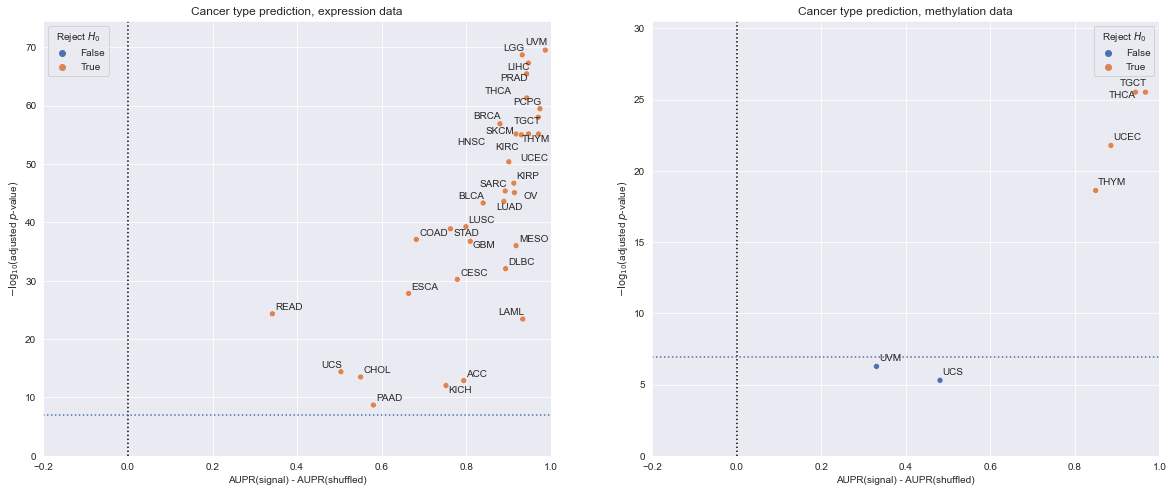

In [18]:
expression_results_df['nlog10_p'] = -np.log(expression_results_df.corr_pval)
methylation_results_df['nlog10_p'] = -np.log(methylation_results_df.corr_pval)

sns.set({'figure.figsize': (20, 8)})
fig, axarr = plt.subplots(1, 2)
sns.scatterplot(data=expression_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[0])
axarr[0].axvline(x=0, linestyle=':', color='black')
axarr[0].axhline(y=-np.log(0.001), linestyle=':')
axarr[0].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[0].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[0].set_xlim((-0.2, 1.0))
axarr[0].set_ylim((0, expression_results_df.nlog10_p.max() + 5))
axarr[0].legend(title=r'Reject $H_0$')
axarr[0].set_title(r'Cancer type prediction, expression data')
sns.scatterplot(data=methylation_results_df, x='delta_mean', y='nlog10_p', hue='reject_null',
                hue_order=[False, True], ax=axarr[1])
axarr[1].axvline(x=0, linestyle=':', color='black')
axarr[1].axhline(y=-np.log(0.001), linestyle=':')
axarr[1].set_xlabel('AUPR(signal) - AUPR(shuffled)')
axarr[1].set_ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
axarr[1].set_xlim((-0.2, 1.0))
axarr[1].set_ylim((0, methylation_results_df.nlog10_p.max() + 5))
axarr[1].legend(title=r'Reject $H_0$')
axarr[1].set_title(r'Cancer type prediction, methylation data')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        # if point['sig']:
        text_labels.append(
            ax.text(point['x']+.005, point['y']+.2, str(point['gene']))
        )
    return text_labels
    

text_labels_expression = label_points(expression_results_df['delta_mean'],
                                      expression_results_df['nlog10_p'],
                                      expression_results_df.identifier,
                                      expression_results_df.reject_null,
                                      axarr[0])
adjust_text(text_labels_expression, ax=axarr[0])

text_labels_methylation = label_points(methylation_results_df['delta_mean'],
                                       methylation_results_df['nlog10_p'],
                                       methylation_results_df.identifier,
                                       methylation_results_df.reject_null,
                                       axarr[1])
adjust_text(text_labels_methylation, ax=axarr[1])

In [11]:
compare_results_df = au.compare_results(methylation_df,
                                        pancancer_df=expression_df,
                                        identifier='cancer_type',
                                        metric='aupr',
                                        correction=True,
                                        correction_method='fdr_bh',
                                        correction_alpha=0.001,
                                        verbose=True)
compare_results_df.head()

shapes unequal for UCEC, skipping
shapes unequal for THCA, skipping
shapes unequal for TGCT, skipping
shapes unequal for THYM, skipping
shapes unequal for UVM, skipping
shapes unequal for UCS, skipping


,identifier,delta_mean,p_value,corr_pval,reject_null
0,READ,0.033659,0.262173,0.321758,False
1,SKCM,0.042094,0.000406,0.001565,False
2,LAML,-0.050033,0.359354,0.421851,False
3,MESO,0.104537,0.089028,0.160251,False
4,LUSC,0.295726,0.000003,0.000011,True


6

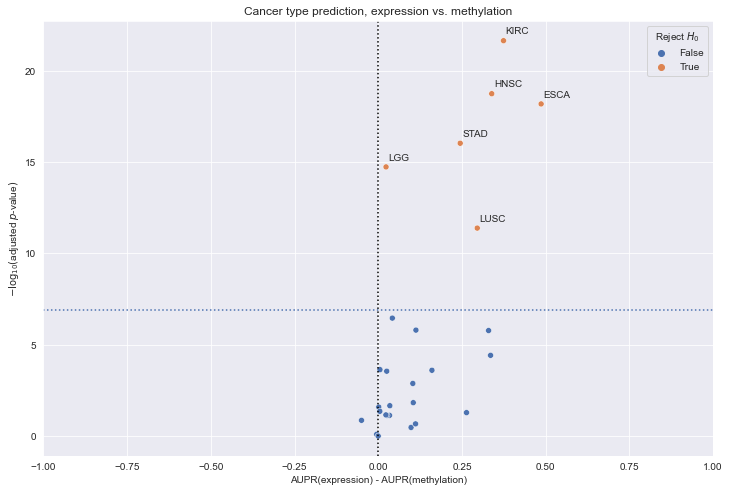

In [19]:
compare_results_df['nlog10_p'] = -np.log(compare_results_df.corr_pval)

sns.set({'figure.figsize': (12, 8)})
sns.scatterplot(data=compare_results_df, x='delta_mean', y='nlog10_p', hue='reject_null')
plt.axvline(x=0, linestyle=':', color='black')
plt.axhline(y=-np.log(0.001), linestyle=':')
plt.xlabel('AUPR(expression) - AUPR(methylation)')
plt.ylabel(r'$-\log_{10}($adjusted $p$-value$)$')
plt.xlim((-1.0, 1.0))
plt.legend(title=r'Reject $H_0$')
plt.title(r'Cancer type prediction, expression vs. methylation')

def label_points(x, y, gene, sig, ax):
    text_labels = []
    a = pd.DataFrame({'x': x, 'y': y, 'gene': gene, 'sig': sig})
    for i, point in a.iterrows():
        if point['sig']:
            text_labels.append(
                ax.text(point['x']+.005, point['y']+.2, str(point['gene']))
            )
    return text_labels

text_labels = label_points(compare_results_df['delta_mean'],
                           compare_results_df['nlog10_p'],
                           compare_results_df.identifier,
                           compare_results_df.reject_null,
                           plt.gca())
adjust_text(text_labels, ax=plt.gca())